# Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns

#increase font size of all elements
sns.set(font_scale=1.5)


# Load the data

In [2]:
import os
import requests

# Data can be found at https://www.kaggle.com/datasets/mustafaali96/weight-height and also at the following url
url = "https://gist.githubusercontent.com/nstokoe/7d4717e96c21b8ad04ec91f361b000cb/raw/bf95a2e30fceb9f2ae990eac8379fc7d844a0196/weight-height.csv"

def download_data(url, force_download=False, **read_csv_kwargs):
    # Donwload data if it is not in disk
    data_path = os.path.join('data', os.path.basename(url.split('?')[0]))
    if not os.path.exists(data_path) or force_download:
        # ensure data dir is created
        os.makedirs('data', exist_ok=True)
        # request data from url
        response = requests.get(url, allow_redirects=True)
        # save file
        with open(data_path, "w") as f:
            # Note the content of the response is in binary form: 
            # it needs to be decoded.
            # The response object also contains info about the encoding format
            # which we use as argument for the decoding
            f.write(response.content.decode(response.apparent_encoding))
    print(f"File saved to {data_path}")

download_data(url)


File saved to data\weight-height.csv


In [3]:
# read csv file
data = pd.read_csv('data/weight-height.csv')
#Convert inches/pounds to m/kg
data.loc[:, 'Weight'] /= 2.205
data.loc[:, 'Height'] /= 39.37

# visualize the first 5 rows
data.head()


,Gender,Height,Weight
0,Male,1.875718,109.702296
1,Male,1.747064,73.610192
2,Male,1.882400,96.481114
3,Male,1.821970,99.792504
4,Male,1.775001,93.582676


## Cook's distance


In [4]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import OLSInfluence

# fit the regression model using statsmodels library
f = 'Weight ~ Height'
model = ols(formula=f, data=data).fit()

# calculate the cooks_distance - the OLSInfluence object contains multiple influence measurements
cook_distance = OLSInfluence(model).cooks_distance
(distance, p_value) = cook_distance

### Outlier ratio with threshold 4/N

At threshold 4/N = 0.00040, 365 samples are considered outliers (3.65% of the samples)


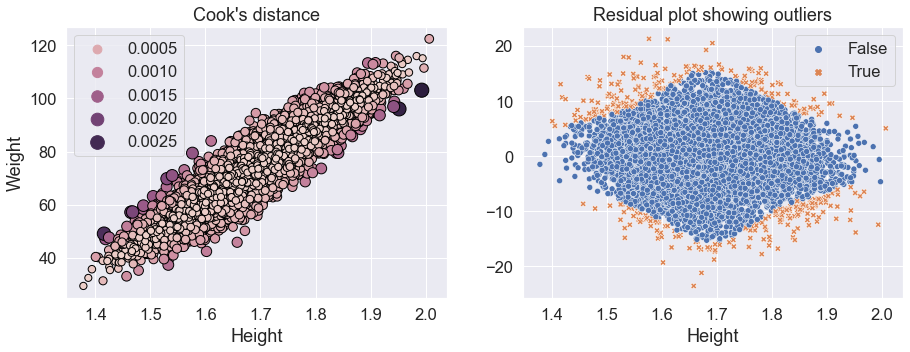

In [51]:
# TODO complete to show the outlier count and ratio
threshold = 4/data.shape[0]
is_outlier = distance > threshold
print(f'At threshold 4/N = {threshold:0.5f}, '
      f'{is_outlier.sum()} samples are considered outliers '
      f'({is_outlier.mean()*100:0.2f}% of the samples)')

# scatter plot - x axis (independent variable height), y-axis (dependent variable weight), size and color of the marks according to its cook's distance
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].set_title('Cook\'s distance')
sns.scatterplot(data=data, x="Height", y="Weight",
                hue=distance, size=distance, ax=axs[0],
                sizes=(50, 200), edgecolor='black', linewidth=1)


axs[1].set_title('Residual plot showing outliers')
sns.scatterplot(data=data, x="Height", y=model.resid, ax=axs[1],
                style=is_outlier, hue=is_outlier)
plt.show()


# Notes

- Dictionary of statistics: "Values of the statistic greater than one suggest that the corresponding observation has undue influence on the estimated regression coefficients." --> he was quoting ARA, and it seems that this consideration is valid if there are more than 2 independent variables
- ARA:  Influential if : $D_i >F_{(0.5,p′,n−p′)}$ (median point of the F distribution with p′ and n-p′ DOF)
  - $ p′= \sum_i v_{ii} $ 
  - $vii = x_i^T (X^TX)^{−1} x_i$ (diagonal element of the hat matix $X^T (X^T X)X$)
  - $x_i^T $ is the $i$-th row of $X$
  - Belsley, Kuh, and Welsch (1980) suggest using $v_{ii} > 2p′/n$ to identify potentially influential points or leverage points."" 

- statsmodels on inlfuence plot: Large leverage points are identified as $hat_i > 2 * ({df}_{model} + 1)/n_{obs}$.
  - could this be the source of 4/N, meaning it is only valid for df_model=1?
  - in any case there is a confusion between leverage and cook's D in this case

In [6]:
from scipy.stats import f as fdist
from numpy.linalg import pinv

n=data.shape[0]
X = data.Height.values.reshape((-1,1))
hat = X @ pinv(X.T @ X ) @ X.T
p=np.trace(hat)

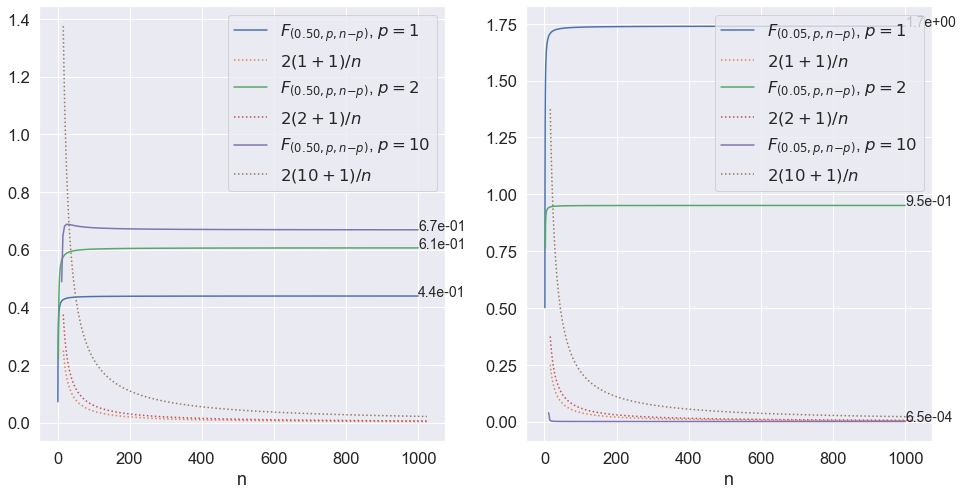

In [69]:
n2 = np.logspace(2,5,80,base=4)
n = np.logspace(-6,3, 80, base=10)
for i, alpha in enumerate([0.5,0.05]):
    plt.subplot(1,2,i+1)
    for p in [1,2, 10]:
        F_val = np.apply_along_axis(
            lambda _n : fdist.pdf(alpha, dfn=p, dfd=_n-p),
            axis=0, arr=n)

        plt.plot(n,F_val, label='$F_{(%0.2f,p,n−p)}$, $p=%0.0f$' % (alpha,p))
        plt.text(x=n[-1], y=F_val[-1],s=f"{F_val[-1]:2.1e}", fontdict=dict(fontsize=14))


        lev_lim = 2*(p + 1)/n2
        plt.plot(n2,lev_lim, ':', label=f'$2({p}+1)/n$')


    # plt.plot(n2,4/n2, ':', label='$4/n$')
    # plt.yscale('log')
    plt.xlabel('n')
    plt.legend()

plt.gcf().set_size_inches(16,8)

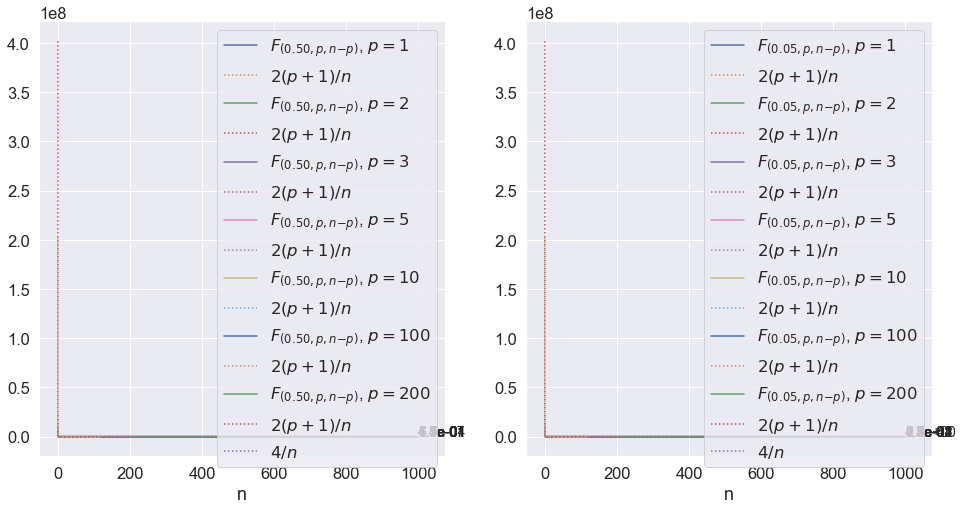

In [ ]:
for i, alpha in enumerate([0.5,0.05]):
    n = np.logspace(-6,3, 80, base=10)
    plt.subplot(1,2,i+1)
    for p in [1,2, 3,5, 10, 100, 200]:
        F_val = np.apply_along_axis(
            lambda _n : fdist.pdf(alpha, dfn=p, dfd=_n-p),
            axis=0, arr=n)

        plt.plot(n,F_val, label='$F_{(%0.2f,p,n−p)}$, $p=%0.0f$' % (alpha,p))
        plt.text(x=n[-1], y=F_val[-1],s=f"{F_val[-1]:2.1e}", fontdict=dict(fontsize=14))

        lev_lim = 2*(p + 1)/n
        plt.plot(n,lev_lim, ':', label='$2(p+1)/n$')

    n=np.logspace(2,5,80,base=4)
    plt.plot(n,4/n, ':', label='$4/n$')
    # plt.yscale('log')
    plt.xlabel('n')
    plt.legend()

plt.gcf().set_size_inches(16,8)

## Comments
- 4/N maybe comes from an upperbound of the F 0.5 threshold for large p (i.e. large number of variables, > 100) and large n (number of samples, > 200)
- For smaller p and n, it is comming out of nowhere....
- Maybe if it was set using a smaler alpha (meaning less tolerance for parameter change due to the sample). In this case it starts working as an upperbound at n_vars =10 already, and also for smaller N.
- It does not make sense at all for p={1,2}

In [50]:
X.var()

0.009549691546400358